<a href="https://colab.research.google.com/github/seb-jul/deeplearningproject/blob/main/DL_Hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Projet Deep Learning FER
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install keras-tuner --upgrade

df=pd.read_csv('fer2013.csv')

print(f'{df.shape}\n{df.head(1)}')
print(f'\nNumber of emotions : {len(pd.unique(df["emotion"]))}')
print(f'Usage : {pd.unique(df["Usage"])}')


#Because of the training set informations, we know that:

emotions_list = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral') # Each emotion is associated by it's index
img_size = (48,48) # 2D image size

test_sample = 10000

test_image  = np.array(df.iloc[test_sample]["pixels"].split(" "),'float32')
plt.title(f'emotion : {emotions_list[df.iloc[test_sample]["emotion"]]}')
plt.imshow(test_image.reshape(img_size))

def dataPreparation(df):
  df_transformed = df.copy()

  training = df_transformed[df_transformed['Usage']=='Training']
  testing = df_transformed[df_transformed['Usage']=='PublicTest']

  X_train,X_test,Y_train,Y_test = training['pixels'].to_numpy(), testing['pixels'].to_numpy(),training['emotion'].to_numpy(),testing['emotion'].to_numpy()

  X_train = [np.array(elem.split(' '),'float32').reshape(48, 48, 1) for elem in X_train]
  X_test = [np.array(elem.split(' '),'float32').reshape(48, 48, 1) for elem in X_test]

  Y_train=np_utils.to_categorical(Y_train, num_classes=7)  
  Y_test=np_utils.to_categorical(Y_test, num_classes=7)

  X_train = np.array(X_train,'float32')
  Y_train = np.array(Y_train,'float32')  
  X_test = np.array(X_test,'float32')  
  Y_test = np.array(Y_test,'float32')

  #X_train /= 255
  #X_test /= 255

  X_train = (X_train - np.mean(X_train))/np.std(X_train)
  X_test = (X_test - np.mean(X_test))/np.std(X_test)
  
  return X_train,X_test,Y_train,Y_test

from keras.utils import np_utils  

X_train,X_test,Y_train,Y_test = dataPreparation(df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Projet Deep Learning FER
(35887, 3)
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training

Number of emotions : 7
Usage : ['Training' 'PublicTest' 'PrivateTest']


In [13]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential  
from keras.layers import Dense, Dropout, Activation, Flatten  
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from tensorflow.keras import optimizers
from keras.regularizers import l2  
from keras.utils import np_utils   


def build_model(hp):  
  model = keras.models.Sequential()  

  #1st convolution layer
  
  #model.add(Conv2D(hp.Int("conv_1_filter", min_value=64, max_value=128, step=64), 
                   #kernel_size=hp.Choice('conv_1_kernel', values = [3,4]),
                   #activation='relu', input_shape=(X_train.shape[1:])))
  model.add(Conv2D(64, (4,4), activation='relu', input_shape=(X_train.shape[1:])))
  #model.add(Conv2D(hp.Int("conv_2_filter", min_value=64, max_value=128, step=64), 
                   #kernel_size=hp.Choice('conv_2_kernel', values = [3,4]),
                   #activation='relu'))
  model.add(Conv2D(64, (4,4), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
  model.add(Dropout(hp.Float("dropout_1", min_value=0.3, max_value=0.5, default=0.3,step=0.1)))

  #2nd convolution layer

  model.add(Conv2D(hp.Int("conv_3_filter", min_value=64, max_value=128, step=64), 
                   kernel_size=hp.Choice('conv_3_kernel', values = [3,4]),
                   activation='relu'))
  model.add(Conv2D(hp.Int("conv_4_filter", min_value=64, max_value=128, step=64), 
                   kernel_size=hp.Choice('conv_4_kernel', values = [3,4]),
                   activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
  model.add(Dropout(hp.Float("dropout_2", min_value=0.3, max_value=0.5, default=0.3,step=0.1)))

  #3nd convolution layer

  model.add(Conv2D(hp.Int("conv_5_filter", min_value=64, max_value=128, step=64), 
                   kernel_size=hp.Choice('conv_5_kernel', values = [3,4]),
                   activation='relu'))
  model.add(Conv2D(hp.Int("conv_6_filter", min_value=64, max_value=128, step=64), 
                   kernel_size=hp.Choice('conv_6_kernel', values = [3,4]),
                   activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
  #model.add(Dropout(hp.Float("dropout_3", min_value=0.3, max_value=0.5, default=0.3,step=0.1)))

  model.add(Flatten())  
  
  #fully connected neural networks  
  model.add(Dense(hp.Int("dense_1_unit", min_value=512, max_value=1024, step=512), activation='relu'))
  model.add(Dropout(0.2))  
  model.add(Dense(hp.Int("dense_2_unit", min_value=512, max_value=1024, step=512), activation='relu'))
  model.add(Dropout(0.2))  
  
  model.add(Dense(len(emotions_list), activation='softmax'))
  
  #Compliling the model  
  model.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                metrics=['accuracy'])
  
  return model

In [ ]:
tuner = kt.RandomSearch(build_model,
                        objective = 'val_accuracy', 
                        max_trials = 150,
                        directory = 'Finding_best_3_layer_model',
                        project_name = 'Entrainement_matin_1_10/12') 
                     
tuner.search(X_train, Y_train, epochs = 15, validation_data = (X_test, Y_test), callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', min_delta=0.01, patience=4)])

In [ ]:
# Which was the best model?
best_model = tuner.get_best_models(1)[0]

# What were the best hyperparameters?
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [ ]:
#Saving the best model to use it later on  
fer_json = best_model.to_json()  
with open("meilleur_modele_10_dec_3_layers.json", "w") as json_file:  
    json_file.write(fer_json)  
best_model.save_weights("meilleur_modele_10_dec_3_layers.h5")

In [14]:
from keras.initializers import glorot_uniform
import tensorflow as tf
from sklearn.metrics import accuracy_score
#Reading the model from JSON file
with open('meilleur_modele_10_dec_3_layers.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('meilleur_modele_10_dec_3_layers.h5')

predict_x  = model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

accuracy_score([np.argmax(elem) for elem in Y_test],classes_x)

0.5979381443298969

In [19]:
#Test pour l'entrainer avec les bons paramètres mais sans initialiser les poids

from keras.initializers import glorot_uniform
import tensorflow as tf
from sklearn.metrics import accuracy_score
#Reading the model from JSON file
with open('meilleur_modele_10_dec_3_layers.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 

#model = tf.keras.models.model_from_json(json_savedModel)

model.compile(loss="categorical_crossentropy",optimizer=optimizers.Adam(learning_rate=1e-3),metrics=['accuracy'])
history=model.fit(X_train, Y_train,batch_size=32,epochs=15,validation_data=(X_test, Y_test),shuffle=True)

Epoch 1/15
898/898 [==============================] - 16s 16ms/step - loss: 1.2683 - accuracy: 0.5191 - val_loss: 1.2120 - val_accuracy: 0.5383
Epoch 2/15
898/898 [==============================] - 10s 11ms/step - loss: 1.2092 - accuracy: 0.5415 - val_loss: 1.1973 - val_accuracy: 0.5428
Epoch 3/15
898/898 [==============================] - 10s 11ms/step - loss: 1.1596 - accuracy: 0.5629 - val_loss: 1.1710 - val_accuracy: 0.5631
Epoch 4/15
898/898 [==============================] - 10s 11ms/step - loss: 1.1189 - accuracy: 0.5798 - val_loss: 1.1531 - val_accuracy: 0.5670
Epoch 5/15
898/898 [==============================] - 10s 11ms/step - loss: 1.0849 - accuracy: 0.5922 - val_loss: 1.1301 - val_accuracy: 0.5723
Epoch 6/15
898/898 [==============================] - 10s 11ms/step - loss: 1.0605 - accuracy: 0.6021 - val_loss: 1.1674 - val_accuracy: 0.5734
Epoch 7/15
898/898 [==============================] - 10s 11ms/step - loss: 1.0384 - accuracy: 0.6118 - val_loss: 1.1156 - val_accuracy:

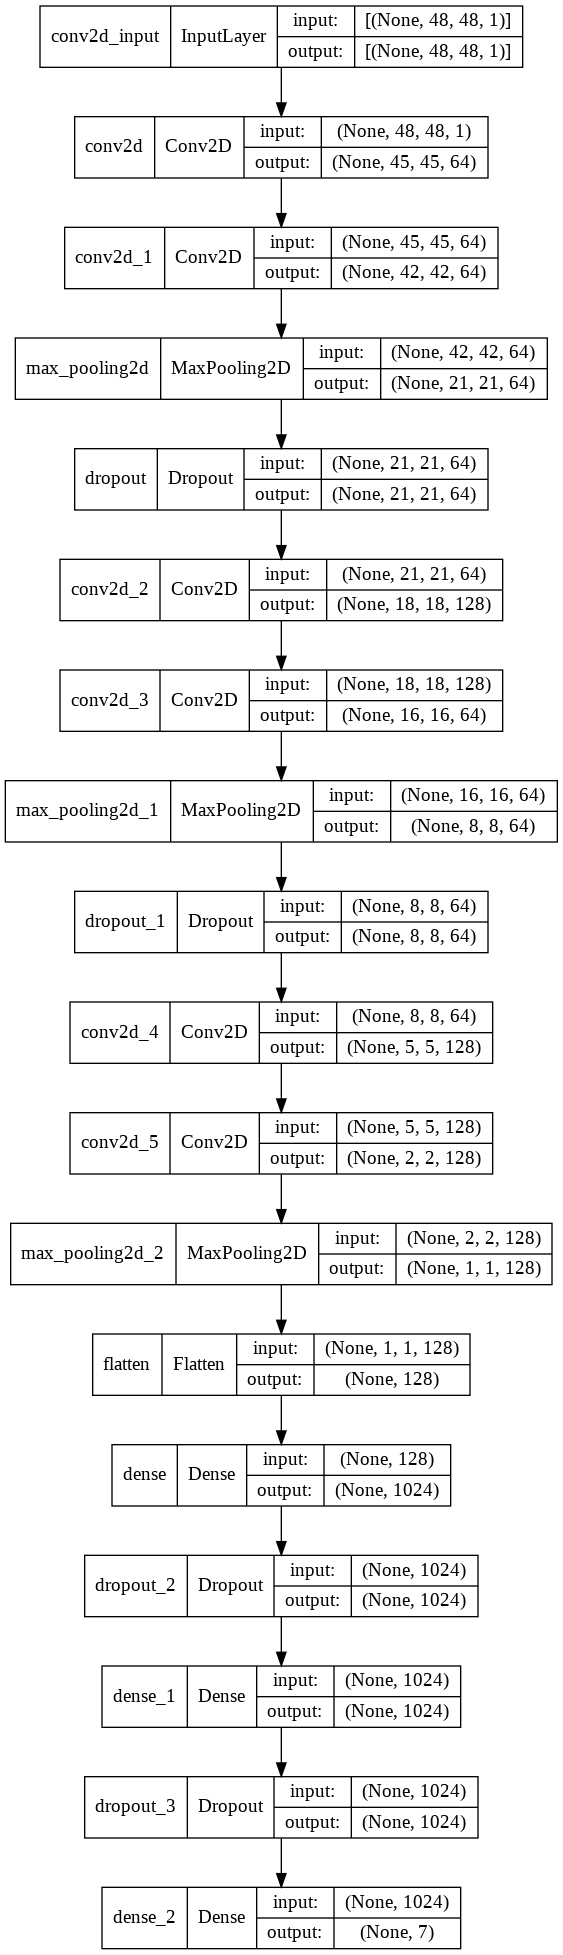

In [23]:
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=400, height=200)

In [ ]:
#Saving the model 
fer_json = model.to_json()  
with open("modele_entraine_66_61_accuracy.json", "w") as json_file:  
    json_file.write(fer_json)  
model.save_weights("modele_entraine_66_61_accuracy.h5")

In [34]:
from keras.initializers import glorot_uniform
import tensorflow as tf
from sklearn.metrics import accuracy_score
#Reading the model from JSON file
#with open('modele_entraine_66_61_accuracy.json', 'r') as json_file:
#    json_savedModel= json_file.read()
#load the model architecture 

#model = tf.keras.models.model_from_json(json_savedModel)
#model.load_weights('modele_entraine_66_61_accuracy.h5')

predict_y  = model.predict(X_test)
classes_y=np.argmax(predict_y,axis=1)

accuracy_score([np.argmax(elem) for elem in Y_test],classes_x)

0.5979381443298969

In [ ]:
!pip install ipympl

from matplotlib import pyplot as plt
%matplotlib widget

from google.colab import output
output.disable_custom_widget_manager()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
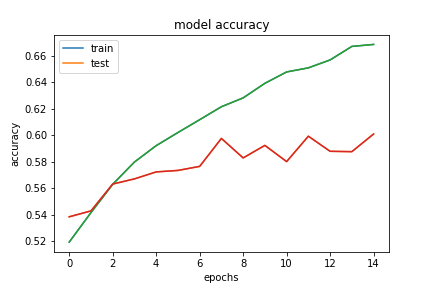

In [45]:
import keras
from matplotlib import pyplot as plt
#%matplotlib widget
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#pip install mlxtend --upgrade --no-deps

{y:"angry",angry:259,disgust:4,fear:33,happy:24,sad:73,surprise:15,neutral:59},
{y:"disgust",angry:15,disgust:22,fear:4,happy:3,sad:8,surprise:0,neutral:4},
{y:"fear",angry:68,disgust:2,fear:151,happy:24,sad:100,surprise:70,neutral:81},
{y:"happy",angry:30,disgust:0,fear:10,happy:750,sad:30,surprise:28,neutral:47},
{y:"sad",angry:67,disgust:1,fear:92,happy:51,sad:271,surprise:18,neutral:153},
{y:"surprise",angry:13,disgust:0,fear:26,happy:21,sad:10,surprise:332,neutral:13},
{y:"neutral",angry:31,disgust:0,fear:36,happy:73,sad:82,surprise:13,neutral:372},


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
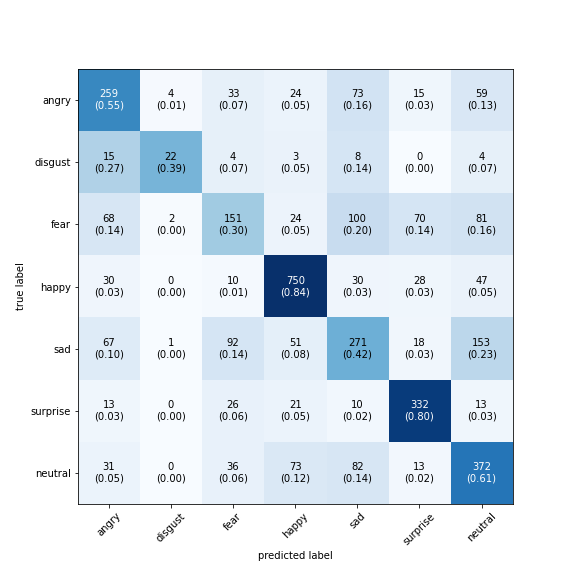

In [46]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
mat = confusion_matrix([np.argmax(elem) for elem in Y_test],classes_y)
plot_confusion_matrix(conf_mat = mat, figsize=(8,8), show_normed = True, class_names=emotions_list)
i=0
for elem in mat:
  print('{y:"'+emotions_list[i]+'",'+emotions_list[0]+':'+str(elem[0])+','+emotions_list[1]+':'+str(elem[1])+','+emotions_list[2]+':'+str(elem[2])+','+emotions_list[3]+':'+str(elem[3])+','+emotions_list[4]+':'+str(elem[4])+','+emotions_list[5]+':'+str(elem[5])+','+emotions_list[6]+':'+str(elem[6])+'},')
  i+=1

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support([np.argmax(elem) for elem in Y_test], classes_y,average='macro')

(0.5909532907759665, 0.5700830336222317, 0.5758685553186405, None)

In [40]:
%cd /content/drive/MyDrive/Projet Deep Learning FER/Images test

/content/drive/MyDrive/Projet Deep Learning FER/Images test


In [47]:
import cv2
from keras.preprocessing import image

#neutral.png
#happy_test.jpg#SmilingGirl
#angry.jpg
#sad.jpg
#disguss.png
#surprise.png
#fear.png

img = cv2.imread('surprise.png')
plt.imshow(img)
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
print(face_cascade)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
for (x,y,w,h) in faces:
  roi_gray=gray[y:y+w,x:x+h]
  roi_gray=cv2.resize(roi_gray,(48,48))
  img_pixels = image.img_to_array(roi_gray)  
  img_pixels = np.expand_dims(img_pixels, axis = 0) 
print(img_pixels.shape)
print(f'Emotion found: {emotions_list[np.argmax(model.predict(img_pixels))]} with {np.max(model.predict(img_pixels))*100}% of precision')

<CascadeClassifier 0x7f98fcb27570>
(1, 48, 48, 1)
Emotion found: surprise with 99.94609951972961% of precision
